#  Прогнозирование заказов такси

Чтобы привлекать больше водителей в период пиковой нагрузки у зоны аэропорта, нужно спрогнозировать количество заказов такси на следующий час. В проекте разрабатывается модель для предсказания спроса.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

 Количество заказов - целевой признак, находится в столбце `num_orders`.

## Подготовка

In [1]:
!pip install pandas-profiling
!pip install --user --upgrade catboost
!pip install --user --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install lightgbm

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import pandas as pd
import pandas_profiling

import numpy as np
import random
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn import model_selection

from sklearn.ensemble import  RandomForestRegressor 
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

import catboost
from catboost import CatBoostRegressor, Pool, metrics, cv

import lightgbm as lgb
from lightgbm import LGBMRegressor

print('Cat Boost version', catboost.__version__)
print('LightGBM version', lgb.__version__) #выводим номер версии

Cat Boost version 1.0.6
LightGBM version 3.3.1


In [3]:
np.random.seed(12345)

In [4]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
#строки date выполняюит роль индексов и столбец [0] читается как даты

In [5]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.sort_index(inplace=True)

`date` так же является индексом для строк. Наш датасет представлей за период с 2018-03-01 по 2018-08-31. 

Целевой признак `num_orders`(количество заказов)

## Анализ

In [8]:
data.index.is_monotonic

True

данные непрерывны

In [9]:
data = data.resample('1H').sum()

Ресемплируем объекты датасета, суммируем все заказы такси за один час

<AxesSubplot:xlabel='datetime'>

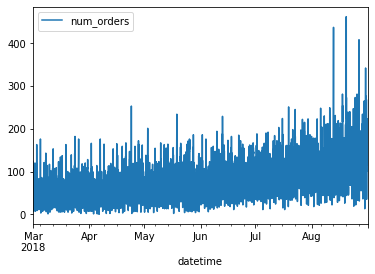

In [10]:
data.plot(ax=plt.gca())

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия.

In [11]:
decomposed = seasonal_decompose(data)

<AxesSubplot:xlabel='datetime'>

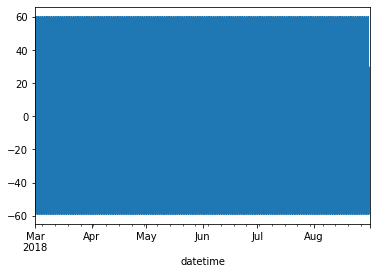

In [12]:
decomposed.seasonal.plot(ax=plt.gca())

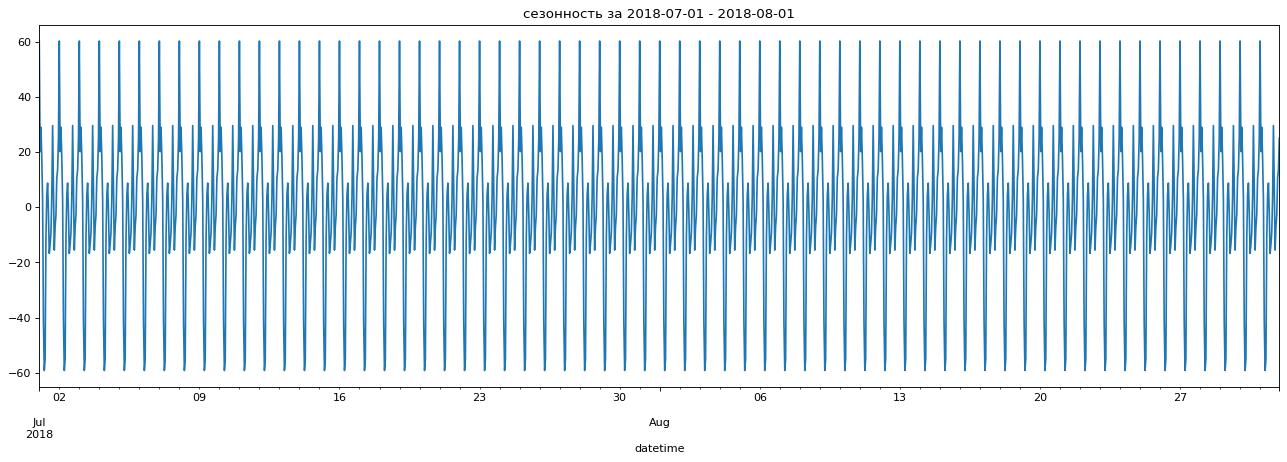

In [13]:
plt.figure(figsize=(20, 6), dpi=80)
decomposed.seasonal.loc['2018-07-01':,].plot(ax=plt.gca())
plt.title('сезонность за 2018-07-01 - 2018-08-01')
plt.show()

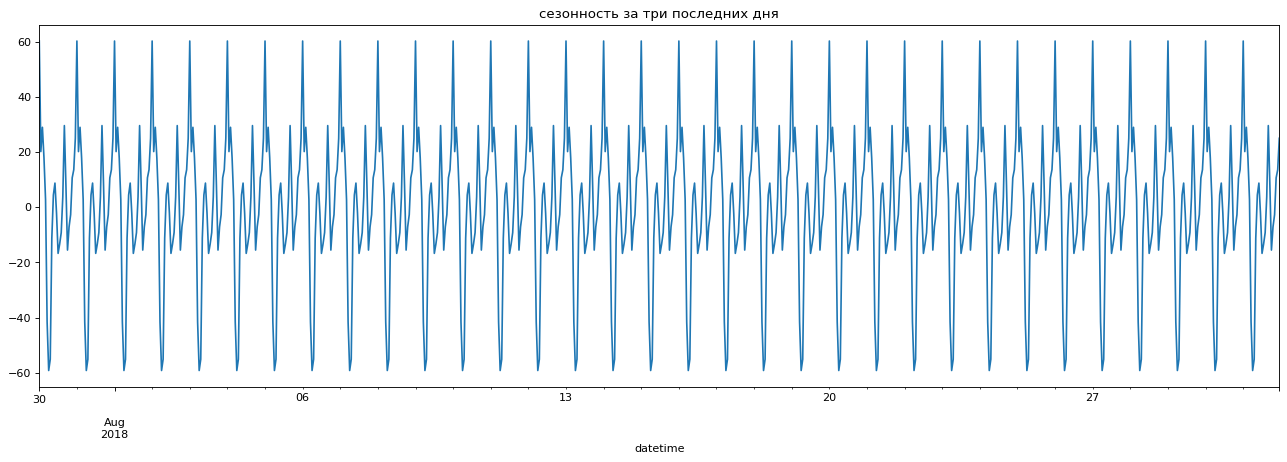

In [14]:
plt.figure(figsize=(20, 6), dpi=80)
decomposed.seasonal.loc['2018-07-30':,].plot(ax=plt.gca())
plt.title('сезонность за три последних дня')
plt.show()

Сезонные изменения в конкретном случае происходят в течение суток. 

<AxesSubplot:xlabel='datetime'>

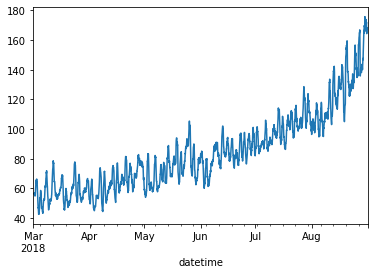

In [15]:
decomposed.trend.plot(ax=plt.gca())

Тренд - постепенное повышение числа заказом, более стремительный рост их количества летом.

<AxesSubplot:xlabel='datetime'>

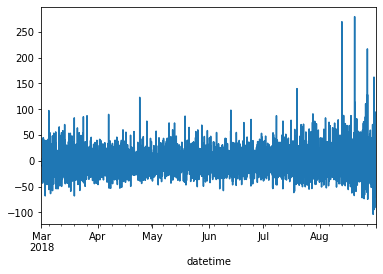

In [16]:
decomposed.resid.plot(ax=plt.gca())

Остатки стабильны. Есть несколько сильно выбивающихся значений в августе

In [17]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Обучение

Создаем признаки - месяц, день, день недели когда были сделаны заказы

In [18]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

Скользящее среднее как признак задаёт общий тренд временного ряда.

In [19]:
def make_features(data, max_lag, rolling_size):
    df=data.copy()
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df.iloc[:,0].shift(lag)
        
    df['rolling_mean'] = df.iloc[:,0].shift().rolling(rolling_size).mean() 
    return df
    # shift() помогает не учитывать текущее значение временого ряда

In [20]:
df = make_features(data,72,2)

Делим данные на обучающую, валидационную и тестовую выборку

In [21]:
df

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.5
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,111.0,212.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,94.0,171.5
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,55.0,136.0,126.0,163.0,152.0,234.0,179.0,160.0,189.0,145.0


In [22]:
df=df.dropna()
train, test = train_test_split(df, shuffle=False, test_size=0.1) #shuffle=False, данные не перемешиваются


x = train.drop('num_orders',axis=1)
y = train['num_orders']

x_train, x_valid, y_train, y_valid = train_test_split( x, y, shuffle=False, test_size=0.2 )

x_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

In [23]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train= scaler.transform(x_train)
x_valid= scaler.transform(x_valid)
x_test= scaler.transform(x_test)

### CatBoost

Создаем объект Pool для передачи данных бустингу

In [24]:
train_pool = Pool(
    data=x_train,
    label=y_train
)

valid_pool = Pool(
    data=x_valid,
    label=y_valid
)

Попробуем идти с большим шагом обучения 0.07. Метрикой качества выбираем RMSE. Задаем параметр `early_stopping_rounds`, чтобы уберечь модель от переобучения. Максимум итераций соответствует максимальному числу деревьев

In [25]:
model_cat_1 = CatBoostRegressor(iterations=3000,
                                learning_rate =0.03,
                                custom_metric=['RMSE'],
                                early_stopping_rounds=100,
                                random_state=12345)

In [26]:
%%time
model_cat_1.fit(train_pool, eval_set=valid_pool, verbose=30, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 33.8141800	test: 54.2250329	best: 54.2250329 (0)	total: 74.3ms	remaining: 3m 42s
30:	learn: 24.6623246	test: 42.0261300	best: 42.0261300 (30)	total: 471ms	remaining: 45.2s
60:	learn: 21.4804234	test: 37.0337978	best: 37.0337978 (60)	total: 874ms	remaining: 42.1s
90:	learn: 20.1101520	test: 34.4638002	best: 34.4638002 (90)	total: 1.29s	remaining: 41.2s
120:	learn: 19.3631272	test: 33.0757640	best: 33.0757640 (120)	total: 1.7s	remaining: 40.4s
150:	learn: 18.8017077	test: 32.3851678	best: 32.3851678 (150)	total: 2.09s	remaining: 39.5s
180:	learn: 18.3719417	test: 31.9403779	best: 31.9403779 (180)	total: 2.53s	remaining: 39.4s
210:	learn: 17.9520075	test: 31.5371296	best: 31.5371296 (210)	total: 2.93s	remaining: 38.7s
240:	learn: 17.5876612	test: 31.3357566	best: 31.3357566 (240)	total: 3.35s	remaining: 38.3s
270:	learn: 17.2453406	test: 31.1565577	best: 31.1536788 (269)	total: 3.76s	remaining: 37.9s
300:	learn: 16.8788441	test: 31.0538272	best: 31.0538272 (300)	total: 4.15s	rem

Обучаем вторую модель. Шаг обучения делаем меньше

In [27]:
model_cat_2 = CatBoostRegressor(iterations=2000,
                                learning_rate =0.07,
                                custom_metric=['RMSE'],
                                l2_leaf_reg=3,
                                random_strength=1,
                                one_hot_max_size=2,
                                leaf_estimation_method = 'Newton',
                                early_stopping_rounds=100)

In [28]:
%%time
model_cat_2.fit(train_pool, eval_set=valid_pool, verbose=30, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 33.1930443	test: 53.7953833	best: 53.7953833 (0)	total: 16ms	remaining: 31.9s
30:	learn: 20.8371966	test: 35.6160124	best: 35.6160124 (30)	total: 421ms	remaining: 26.7s
60:	learn: 18.9964503	test: 32.4905751	best: 32.4868330 (59)	total: 791ms	remaining: 25.1s
90:	learn: 18.0032162	test: 31.4781240	best: 31.4781240 (90)	total: 1.16s	remaining: 24.4s
120:	learn: 17.1799249	test: 31.0268906	best: 31.0173234 (119)	total: 1.54s	remaining: 23.9s
150:	learn: 16.4104368	test: 30.9412465	best: 30.9412465 (150)	total: 1.9s	remaining: 23.3s
180:	learn: 15.6325777	test: 30.6564851	best: 30.6564851 (180)	total: 2.28s	remaining: 22.9s
210:	learn: 14.9076094	test: 30.5615869	best: 30.5019610 (195)	total: 2.74s	remaining: 23.2s
240:	learn: 14.3183147	test: 30.5226584	best: 30.4619475 (234)	total: 3.12s	remaining: 22.8s
270:	learn: 13.7214589	test: 30.4807369	best: 30.4407144 (265)	total: 3.52s	remaining: 22.5s
300:	learn: 13.1724605	test: 30.4566330	best: 30.4200410 (280)	total: 3.92s	remain

#### Анализ модели

CatBoost дает хорошие показания на метрике RMSE (30 при необходимом минимуме 48). Так же модель быстро обучается и дает предсказания, что важно, если нужно прогнозировать число заказов на ближайшее время)

#### CatBoost. Кросс-валидация

In [29]:
params={
    'loss_function': 'RMSE',
    'iterations': 1000,
    'learning_rate':0.7,
    'early_stopping_rounds': 20
}

In [30]:
cv_data = cv(
    params=params,
    pool = Pool(x, label=y),
    fold_count = 5,
    shuffle =False,
    plot=True,
    stratified = True,
    verbose =False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 32.75066535
bestIteration = 38

Training on fold [1/5]



bestTest = 23.20404977
bestIteration = 7

Training on fold [2/5]



bestTest = 22.49641072
bestIteration = 12

Training on fold [3/5]



bestTest = 22.2903952
bestIteration = 8

Training on fold [4/5]



bestTest = 29.34528502
bestIteration = 1



In [31]:
cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,41.946184,9.712166,42.241861,1.690587
1,1,30.484831,8.244922,28.945942,1.575392
2,2,29.394691,8.122527,25.791833,1.403731
3,3,28.811427,7.768605,24.451192,1.466219
4,4,28.475148,7.342378,23.842554,1.348856


In [32]:
cv_data['test-RMSE-mean'].mean()

27.661802434131488

На кросс-валидации модель показала даже лучшие результаты

### LightGBM

In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'metric': ['RMSE'],
    'learning_rate': 0.1,
    "num_leaves": 120,  
    "max_bin": 500,
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid)
lgb_test = lgb.Dataset(x_test, y_test)

In [34]:
lgbm_model_1 = LGBMRegressor()

In [35]:
%%time
lgbm_model_1 = lgb.train(params,
                       train_set=lgb_train,
                       valid_sets=lgb_valid,
                       early_stopping_rounds=30,
                       num_boost_round=500
)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 52.0808
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 49.7848
[3]	valid_0's rmse: 47.7127
[4]	valid_0's rmse: 45.9284
[5]	valid_0's rmse: 44.4598
[6]	valid_0's rmse: 42.9316
[7]	valid_0's rmse: 41.6941
[8]	valid_0's rmse: 40.408
[9]	valid_0's rmse: 39.364
[10]	valid_0's rmse: 38.5717
[11]	valid_0's rmse: 37.8213
[12]	valid_0's rmse: 37.1398
[13]	valid_0's rmse: 36.4341
[14]	valid_0's rmse: 35.8318
[15]	valid_0's rmse: 35.3076
[16]	valid_0's rmse: 34.7918
[17]	valid_0's rmse: 34.3129
[18]	valid_0's rmse: 33.989
[20]	valid_0's rmse: 33.4359
[21]	valid_0's rmse: 33.2364
[22]	valid_0's rmse: 32.958
[23]	valid_0's rmse: 32.7832
[24]	valid_0's rmse: 32.5684
[25]	valid_0's rmse: 32.3128
[26]	valid_0's rmse: 32.1829
[27]	valid_0's rmse: 32.0831
[28]	valid_0's rmse: 31.9217
[29]	valid_0's rmse: 31.7988
[30]	valid_0's rmse: 31.6166
[31]	valid_0's rmse: 31.5388
[32]	valid_0's rmse: 31.4408
[33]	valid_0's rmse: 31.3672
[34]	valid_0's rmse: 31.

In [36]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'metric': ['RMSE'],
    'learning_rate': 0.4,
    "num_leaves": 150,  
    "max_bin": 700,
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_valid, y_valid)
lgb_test = lgb.Dataset(x_test, y_test)

In [37]:
lgbm_model_2 = LGBMRegressor()

In [38]:
%%time
lgbm_model_2 = lgb. train(params,
                       train_set=lgb_train,
                       valid_sets=lgb_valid,
                       early_stopping_rounds=30,
                       num_boost_round=660
)

[1]	valid_0's rmse: 44.0771
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 38.6165
[3]	valid_0's rmse: 35.8896
[4]	valid_0's rmse: 34.6177
[5]	valid_0's rmse: 34.439
[6]	valid_0's rmse: 33.8352
[7]	valid_0's rmse: 33.1757
[8]	valid_0's rmse: 33.3568
[9]	valid_0's rmse: 33.1423
[10]	valid_0's rmse: 33.1113
[11]	valid_0's rmse: 33.0931
[12]	valid_0's rmse: 33.0816
[13]	valid_0's rmse: 33.2208
[14]	valid_0's rmse: 33.2983
[15]	valid_0's rmse: 33.2858
[16]	valid_0's rmse: 33.4709
[17]	valid_0's rmse: 33.462
[18]	valid_0's rmse: 33.4651
[19]	valid_0's rmse: 33.5338
[20]	valid_0's rmse: 33.5379
[21]	valid_0's rmse: 33.4943
[22]	valid_0's rmse: 33.5567
[23]	valid_0's rmse: 33.6355
[24]	valid_0's rmse: 33.7672
[25]	valid_0's rmse: 33.6923
[26]	valid_0's rmse: 33.713
[27]	valid_0's rmse: 33.6722
[28]	valid_0's rmse: 33.7123
[29]	valid_0's rmse: 33.6572
[30]	valid_0's rmse: 33.7082
[31]	valid_0's rmse: 33.7523
[32]	valid_0's rmse: 33.7025
[33]	valid_0's rmse: 33

#### Анализ модели

LightGBM тоже дает неплохие результаты, но хуже чем Catboost и обучается, предсказывает дольше. Хотя у нас не стоит задачи обучаться быстрее, для модели это можно считать плюсом или минусом

### RandomForest

среди метрик качества в RandomizedSearchCV нет RMSE. Поэтому передадим rmse через метод make_scorer

In [39]:
def rmse (target, predict):
    rmse =mean_squared_error(target, predict)**0.5
    return rmse
 make_scorer(rmse, greater_is_better=False)

Передаем параметры, которые будем подбирать

In [40]:
parameter_space = {'bootstrap': [True, False],
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
'max_features': ['auto', 'sqrt'],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [200, 400, 600, 800, 1000, 2000]
}

In [41]:
ensemble = RandomForestRegressor(random_state=12345)

In [42]:
model_rf = model_selection.RandomizedSearchCV(
    estimator =ensemble,
    param_distributions= parameter_space,
    n_iter=10,
    scoring = make_scorer(rmse, greater_is_better=False),
    verbose =10,
    n_jobs = -1,
    cv = 4
)

In [43]:
%%time
model_rf.fit(x_train,y_train)
print (model_rf.best_score_)
print(model_rf.best_estimator_.get_params())

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 1/4; 1/10] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.3s
[CV 2/4; 1/10] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 2/4; 1/10] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  30.0s
[CV 3/4; 1/10] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 3/4; 1/10] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  31.0s
[CV 4/4; 1/10] START bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10,

In [44]:
ensemble_1 = RandomForestRegressor(bootstrap= False, max_depth = 90, criterion= 'mse', max_features='sqrt',
                                   min_samples_leaf=2, min_samples_split = 5, n_estimators = 200, random_state=12345)

In [45]:
%%time
ensemble_1.fit(x_train,y_train)

CPU times: user 3.31 s, sys: 32 ms, total: 3.35 s
Wall time: 3.35 s


RandomForestRegressor(bootstrap=False, max_depth=90, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=200,
                      random_state=12345)

In [46]:
predict_ens1 = ensemble_1.predict(x_valid)
rmse_ensemble_1= mean_squared_error(y_valid, predict_ens1)**0.5

Вычисляем RMSE на валидационной выборке

In [47]:
rmse_ensemble_1

31.58162918739943

#### Анализ модели

Долго обучается, качество Catboost остается лучшим

### ElasticNetCV

In [50]:
tscv = TimeSeriesSplit(n_splits=5)

In [51]:
model_EN = ElasticNetCV( cv=tscv)
model_EN.fit(x_train, y_train)

ElasticNetCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [52]:
predict_EN = model_EN.predict(x_valid)

In [53]:
rmse_EN = mean_squared_error(y_valid, predict_EN)**0.5
rmse_EN

29.49883184819835

ElasticNetCV очень простая в использовании модель, без дополнительного тюннинга дает хорошие результаты

### LassoCV

In [60]:
model_lasso = LassoCV(cv=tscv)
model_lasso.fit(x_train, y_train)

LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [61]:
predict_lasso = model_lasso.predict(x_valid)

In [62]:
rmse_lasso = mean_squared_error(y_valid, predict_lasso)**0.5
rmse_lasso

29.570011575116194

RMSE моделей колеблется от 29 до 31 

## Тестирование

In [63]:
best_predict = model_EN.predict(x_test)

In [64]:
rmse_bmodel = mean_squared_error(y_test, best_predict)**0.5
rmse_bmodel

43.03702532250816

Попробовала несколько моделей на тестовой выборке.Условие RMSE < 48 выполняется у LassoCV и ElasticNetCV, хотя у model_cat_1 на валидации было 29.9

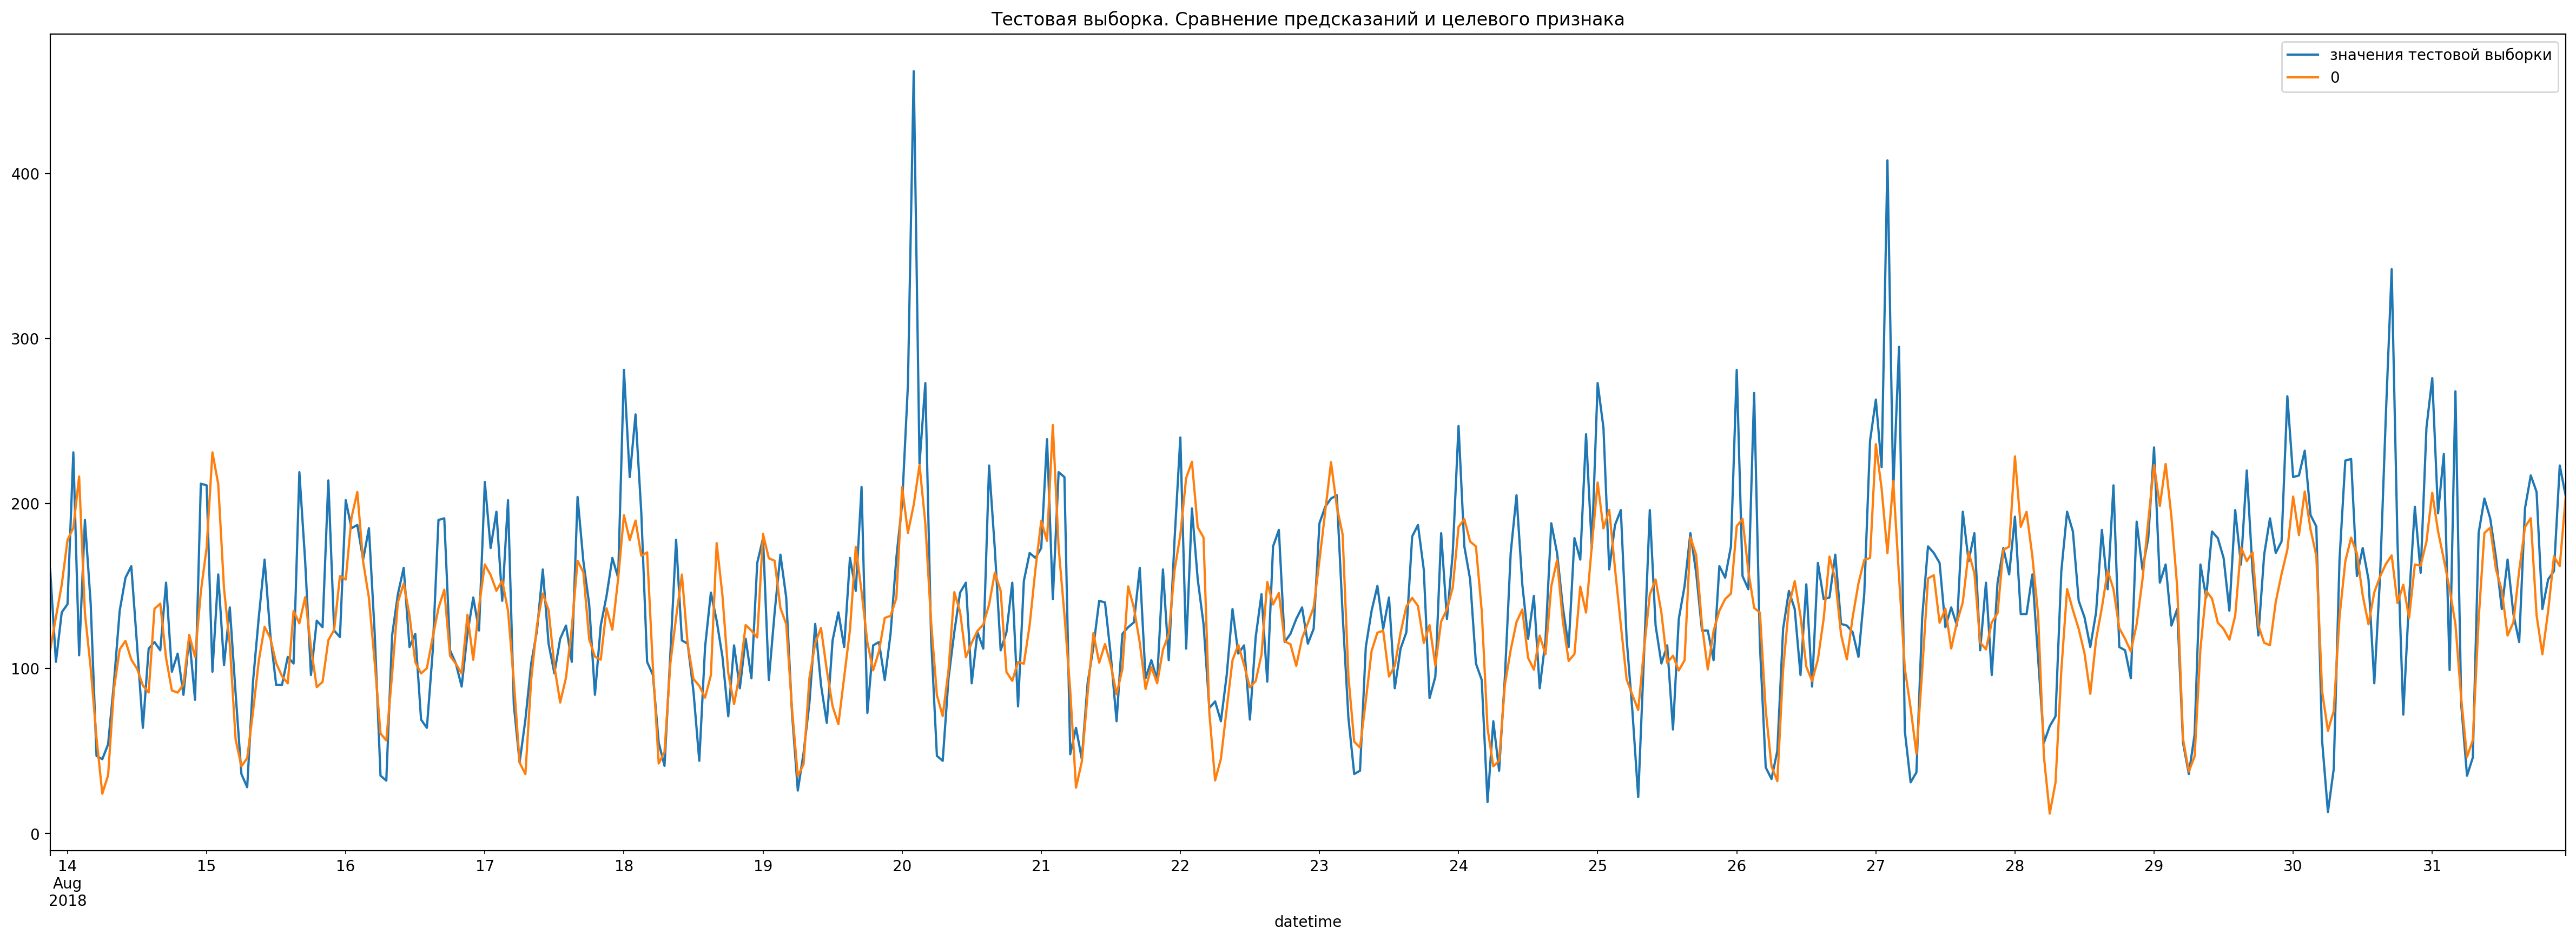

In [89]:
predict_plt=pd.DataFrame(data=best_predict, index =y_test.index)

plt.figure(figsize=(30, 10), dpi=200)
y_test.plot(ax=plt.gca(), label='значения тестовой выборки', legend=True)
predict_plt.plot(ax=plt.gca(), label='предсказания модели', legend=True)
plt.title('Тестовая выборка. Сравнение предсказаний и целевого признака')
plt.show()

Модель в целом заметно ошибается.

## Итог

 Данные были подготовленны и проанализированы. Датасет представляет собой запись данных за полгода. Временной ряд не стационарен.После подготовки признаком и масштабирования были обучены модели с разными параметрами. По итогу лучшей моделью стала ElasticNetCV со значением RMSE - 30.38 на валидационной выборке и RMSE - 43.00 на тестовой.